# Összefoglaló

## 2D Ising-modell
Ez a projekt a kétdimenziós Ising-modell Monte Carlo-szimulációját valósítja meg a Metropolis-algoritmus segítségével. Az Ising-modell egy matematikai modell, amelyet ferromágneses anyagok viselkedésének és fázisátalakulásainak vizsgálatára használnak.

A kétdimenziós Ising-modell egy olyan $L \times L$ rácsból áll, amelynek minden pontjában egy-egy spin található, ami +1 vagy -1 értéket vehet fel. Minden spin kölcsönhatásban van a közvetlen szomszédaival, és a rendszer a Metropolis-algoritmus alapján fejlődik. A szimuláció során a rendszer különböző fizikai jellemzőit (elrendezés energiája és mágnesezettsége) számítjuk ki.

A Metropolis-algoritmus fő lépései a következők:

1. Elkészítjük a kezdeti konfigurációt N db spinnel (a rendszernek $2^L$ lehetőség van).

2. Véletlenszerűen válasszunk ki egy rácspontot, és fordítsuk meg annak a spinjét.

3. Számítsuk ki az energiaváltozást,  $\Delta E$-t. Ha  $\Delta E$ < 0, fogadjuk el a lépést. Ellenkező esetben a lépést valószínűséggel $e^{-ΔE/T}$ fogadjuk el. Ez kielégíti a részletes egyensúly feltételét, és biztosítja, hogy a rendszer egyensúlyi állapotba jusson.

$$
   P_{\text{accept}} =
   \begin{cases}
   1 & \text{if } \Delta E \leq 0 \\
   e^{-\beta \Delta E} & \text{if } \Delta E > 0
   \end{cases}
   $$

4. Ismételjük meg a 2–4. lépéseket.

A kétdimenziós Ising-modell Hamilton-operátora külső mágneses tér (B) jelenlétében a következő alakot ölti:

$$
H(\boldsymbol{s}) = -J \sum_{\langle i, j \rangle} s_i s_j - \mu B \sum_j s_j
$$

Itt $𝑠_i$ jelöli az i-edik rácsponton lévő spint, amely +1 vagy -1 lehet. A $J$ a szomszédos spinek közötti kölcsönhatás erőssége, $μ$ az egyes spinek mágneses momentuma, $B$ pedig a külső mágneses tér erőssége. Az első összeg az összes szomszédos spinpárra vonatkozik, míg a második összeg a rács összes spinjére.

A rendszer másodrendű fázisátalakuláson megy keresztül a kritikus hőmérsékleten, $T_c$-nél. Ha a hőmérséklet kisebb, mint $T_c$ a rendszer mágnesezett állapotba kerül, amelyet ferromágnesesnek vagy rendezett állapotnak nevezünk. Ez a lokális kölcsönhatások miatt globálisan rendezett konfigurációt jelent. Ha a hőmérséklet nagyobb, mint $T_c$ a rendszer rendezetlen, ún. paramágneses állapotba kerül, ahol a spinek között nem alakulnak ki hosszú távú korrelációk.

A kód alapvetően két részből áll: 
1. egy adott hőmérsékleten a kezdeti konfigurációból eljuttatja az elrendezést az egyensúlyi állapotba, majd készít egy animációt a folyamatról
2. egy adott hőmérséklet intervallumról megadott számú hőmérséklet esetén elvégzi az előző rész első felét (eljuttatja egyensúlyba), majd ott további lépések során az adott konfiguráció egyensúlyhoz tartozó energiáját és mágnesezettségét átlagolással meghatározza. Ezt a folyamatot minden hőmérséklet esetén többször elvégzi a kód, majd a kapott egyensúlyi energiákat és mágnesezettségeket a hőmérséklet függvényében ábrázolja két grafikonon. 

# Kód

In [40]:
import numpy as np 
import matplotlib.pyplot as pl
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import HTML

In [41]:
class IsingModel:
    def __init__(self, grid_size, temperature, J, h, mu):
        self.grid_size = grid_size
        self.temperature = temperature
        self.spins = np.random.choice([-1, 1], size=(grid_size, grid_size))
        self.J = J  
        self.h = h
        self.mu = mu

    def energy(self):
        energy = 0
        right = np.roll(self.spins, -1, axis=1)
        down = np.roll(self.spins, -1, axis=0)
        interaction_energy = -self.J * np.sum(self.spins * (right + down)) / 2.0
        field_energy = -self.h * self.mu * np.sum(self.spins)

        return interaction_energy + field_energy
    
    def delta_energy(self, i, j):
        s = self.spins[i, j]
        s_neighbors = (
            self.spins[(i + 1) % self.grid_size, j] +
            self.spins[i, (j + 1) % self.grid_size] +
            self.spins[(i - 1) % self.grid_size, j] +
            self.spins[i, (j - 1) % self.grid_size]
        )
        return 2 * s * (self.J * s_neighbors + self.h * self.mu)

    def magnetization(self):
        return np.sum(self.spins)
    

### 1. rész - Animáció egy adott hőmérsékleten történő egyensúlyba jutásról

#### Függvények

In [42]:
def spin_grid_animation(spin_grids, T, J, h, mu, save_path=None, fps=60):
    fig, ax = plt.subplots(figsize=(6,6), dpi=100)
    img = ax.imshow(spin_grids[0], cmap='plasma', vmin=-1, vmax=1)
    ax.set_title(f'2D Ising Model: T={T:.2f}K, h={h:.2f}T')
    ax.axis('off')
    fig.tight_layout()

    def update(frame):
        img.set_array(spin_grids[frame])
        return [img]

    ani = FuncAnimation(
        fig,
        update,
        frames=len(spin_grids),
        interval=1000/fps,
        blit=True,
        cache_frame_data=False
    )
    
    if save_path:
        if save_path.endswith('.mp4'):
            writer = FFMpegWriter(fps=fps, bitrate=5000)
            ani.save(save_path, writer=writer, dpi=100)
        else:
            ani.save(save_path, writer='pillow', fps=fps)
    
    plt.close(fig)
    return HTML(ani.to_jshtml(fps=fps))

In [43]:
def equilibrium(energies, eps, window): 
    
    if len(energies) < window:
        return False
        
    recent = energies[-window:]
    diffs = np.abs(np.diff(recent))
    
    return np.all(diffs < eps )

In [ ]:
def Metropolis_hastings(ising_model, steps, scalings, eps=1e-3, window=400):

    (J_phys,  mu_phys) = scalings
    energies = []
    magnetizations = []

    spin_grids = []
    step = 0

    in_equilibrium = False
    while not in_equilibrium and step < steps:
            
        i, j = np.random.randint(0, ising_model.grid_size, size=2)
        delta_E = ising_model.delta_energy(i, j)

        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / (ising_model.temperature)):
            ising_model.spins[i, j] *= -1

        energies.append(ising_model.energy())
        magnetizations.append(ising_model.magnetization())        

        if step % 20 == 0:
            spin_grids.append(ising_model.spins.copy())
            in_equilibrium = equilibrium(energies, eps, window)

        if in_equilibrium:
            print(f"Equilibrium reached at step {step}")

        step += 1
    
    E = np.mean(energies[-10:]) # az adott T-hez tartozó egyensúlyi energia
    M = np.mean(magnetizations[-10:]) # az adott T-hez tartozó egyensúlyi mágnesezettség

    return E * J_phys, M * mu_phys, np.array(spin_grids)

#### Szimulációk

In [ ]:
k_B = 1.380649e-23       # J/K
J_phys = 2.0e-21         # J
mu_phys = 9.2740100783e-24      # J/T

T_phys = 50  # K
h_phys = 0.  # T

T = T_phys * (k_B / J_phys)  # Dimensionless temperature
T = 2.1
h = h_phys * (mu_phys / J_phys)  # Dimensionless field
J = 1.0
mu = mu_phys / J_phys  # Dimensionless magnetic moment


grid_size = 16


ising_model = IsingModel(grid_size=grid_size, temperature=T, J=J, h=h, mu=mu)

steps = 1000000
scalings = (J_phys, mu_phys)
energy, magnetization, spin_grids = Metropolis_hastings(ising_model, steps, scalings)

print(f"Final energy: {energy:.4e} J, Magnetization: {magnetization:.4e} J/T")

path = r'D:\Egyetem\Tudományos Programozás\Ising_model_simulation\plots_and_animations\\ising_model_animation_16x16.mp4'



#spin_grid_animation(spin_grids, T_phys, J_phys, h_phys, mu_phys, save_path=path)

Equilibrium reached at step 117700
Final energy: -5.1200e-19 J, Magnetization: -2.3741e-21 J/T


In [ ]:
k_B = 1.380649e-23       # J/K
J_phys = 2.0e-21         # J
mu_phys = 9.2740100783e-24      # J/T

T_phys = 50  # K
h_phys = 0.  # T

T = T_phys * (k_B / J_phys)  # Dimensionless temperature
h = h_phys * (mu_phys / J_phys)  # Dimensionless field
J = 1.0
mu = mu_phys / J_phys  # Dimensionless magnetic moment


grid_size = 60


ising_model = IsingModel(grid_size=grid_size, temperature=T, J=J, h=h, mu=mu)

steps = 50000
scalings = (J_phys, mu_phys)
energy, magnetization, spin_grids = Metropolis_hastings(ising_model, steps, scalings)

print(f"Final energy: {energy:.4e} J, Magnetization: {magnetization:.4e} J/T")

path = r'D:\Egyetem\Tudományos Programozás\Ising_model_simulation\plots_and_animations\\ising_model_animation_60x60.mp4'



spin_grid_animation(spin_grids, T_phys, J_phys, h_phys, mu_phys, save_path=path)

In [ ]:
k_B = 1.380649e-23       # J/K
J_phys = 2.0e-21         # J
mu_phys = 9.2740100783e-24      # J/T

T_phys = 200  # K
h_phys = 0.  # T

T = T_phys * (k_B / J_phys)  # Dimensionless temperature
h = h_phys * (mu_phys / J_phys)  # Dimensionless field
J = 1.0
mu = mu_phys / J_phys  # Dimensionless magnetic moment


grid_size = 100


ising_model = IsingModel(grid_size=grid_size, temperature=T, J=J, h=h, mu=mu)

steps = 40000
scalings = (J_phys, mu_phys)
energy, magnetization, spin_grids = Metropolis_hastings(ising_model, steps, scalings)

print(f"Final energy: {energy:.4e} J, Magnetization: {magnetization:.4e} J/T")

path = r'D:\Egyetem\Tudományos Programozás\Ising_model_simulation\plots_and_animations\\ising_model_animation_100x100.mp4'
spin_grid_animation(spin_grids, T_phys, J_phys, h_phys, mu_phys, save_path=path)

### 2. rész - Az elrendezés energiájának és mágnesezettségének hőmérsékletfüggése

#### Függvények

In [56]:
def plot(T, energies, magnetization, susceptibility, specific_heat):
    
    plt.figure(figsize=(16, 12))
    
    # Energy plot
    plt.subplot(2, 2, 1)
    plt.plot(T, energies, marker='o', linestyle='--', color='IndianRed')
    plt.xlabel("Temperature (K)", fontsize=20)
    plt.ylabel("Energy (J)", fontsize=20)
    plt.axis('tight')
    
    # Magnetization plot
    plt.subplot(2, 2, 2)
    plt.plot(T, abs(magnetization), marker='o', linestyle='--', color='RoyalBlue')
    plt.xlabel("Temperature (K)", fontsize=20)
    plt.ylabel("Magnetization (A·m²)", fontsize=20)
    plt.axis('tight')

    plt.subplot(2, 2, 3)
    plt.plot(T, susceptibility, marker='o', linestyle='--', color='DarkOrange')
    plt.xlabel("Temperature (K)", fontsize=20)
    plt.ylabel("Susceptibility (A²·m⁴/J)", fontsize=20)
    plt.axis('tight')

    plt.subplot(2, 2, 4)
    plt.plot(T, specific_heat, marker='o', linestyle='--', color='DarkGreen')
    plt.xlabel("Temperature (K)", fontsize=20)
    plt.ylabel("Specific Heat (J/K)", fontsize=20)
    plt.axis('tight')

    plt.tight_layout()
    plt.savefig(r'D:\Egyetem\Tudományos Programozás\Ising_model_simulation\plots_and_animations\ising_model_results.png', dpi=300)
    plt.show()

In [ ]:
def Metropolis_hastings_for_equilibrium(ising_model, steps, scalings, eps, window, n, mu_phys, J_phys):

    k_B = 1.380649e-23       # J/K

    J_phys, mu_phys = scalings
    spin_grids = []
    
    step = 0
    equilibrium_reached = False
    beta = 1.0 / ising_model.temperature  

    recent_energies = np.zeros(window)
    energy_index = 0
    filled = False
    
    step = 0
    equilibrium_reached = False
    beta = 1.0 / ising_model.temperature
    
    current_energy = ising_model.energy()
    while not equilibrium_reached and step < steps:

        i, j = np.random.randint(0, ising_model.grid_size, size=2)
        delta_E = ising_model.delta_energy(i, j)

        if delta_E < 0 or np.random.rand() < np.exp(-delta_E * beta):
            ising_model.spins[i, j] *= -1
            current_energy += delta_E

        recent_energies[energy_index] = current_energy
        energy_index = (energy_index + 1) % window

        if not filled and energy_index == 0:
            filled = True

        if filled and step % 20 == 0:
            diffs = np.abs(np.diff(np.roll(recent_energies, -energy_index)))
            if np.all(diffs < eps):
                equilibrium_reached = True
                
        step += 1

    equilibrium_energies = []
    equilibrium_magnetizations = []
    for _ in range(n):
        i, j = np.random.randint(0, ising_model.grid_size, size=2)
        delta_E = ising_model.delta_energy(i, j)

        if delta_E < 0 or np.random.rand() < np.exp(-delta_E * beta):
            ising_model.spins[i, j] *= -1

        equilibrium_energies.append(ising_model.energy())
        equilibrium_magnetizations.append(ising_model.magnetization())

        if step % 50 == 0: 
            spin_grids.append(ising_model.spins.copy())

        step += 1

    equilibrium_energies = np.array(equilibrium_energies)
    equilibrium_magnetizations = np.array(equilibrium_magnetizations)

    E = np.mean(equilibrium_energies)
    M = np.mean(equilibrium_magnetizations)
    susceptibility = beta * np.var(equilibrium_magnetizations) 
    specific_heat = (beta**2) * np.var(equilibrium_energies) / (ising_model.grid_size**2)

    return E * J_phys,  M * mu_phys, susceptibility * mu_phys**2 / J_phys, specific_heat * J_phys**2 / k_B, np.array(spin_grids), equilibrium_energies, equilibrium_magnetizations

In [ ]:
def close_to_critical_temperature(T, T_c, threshold=0.01):
    return np.abs(T - T_c) < threshold

#### Szimuláció

30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30


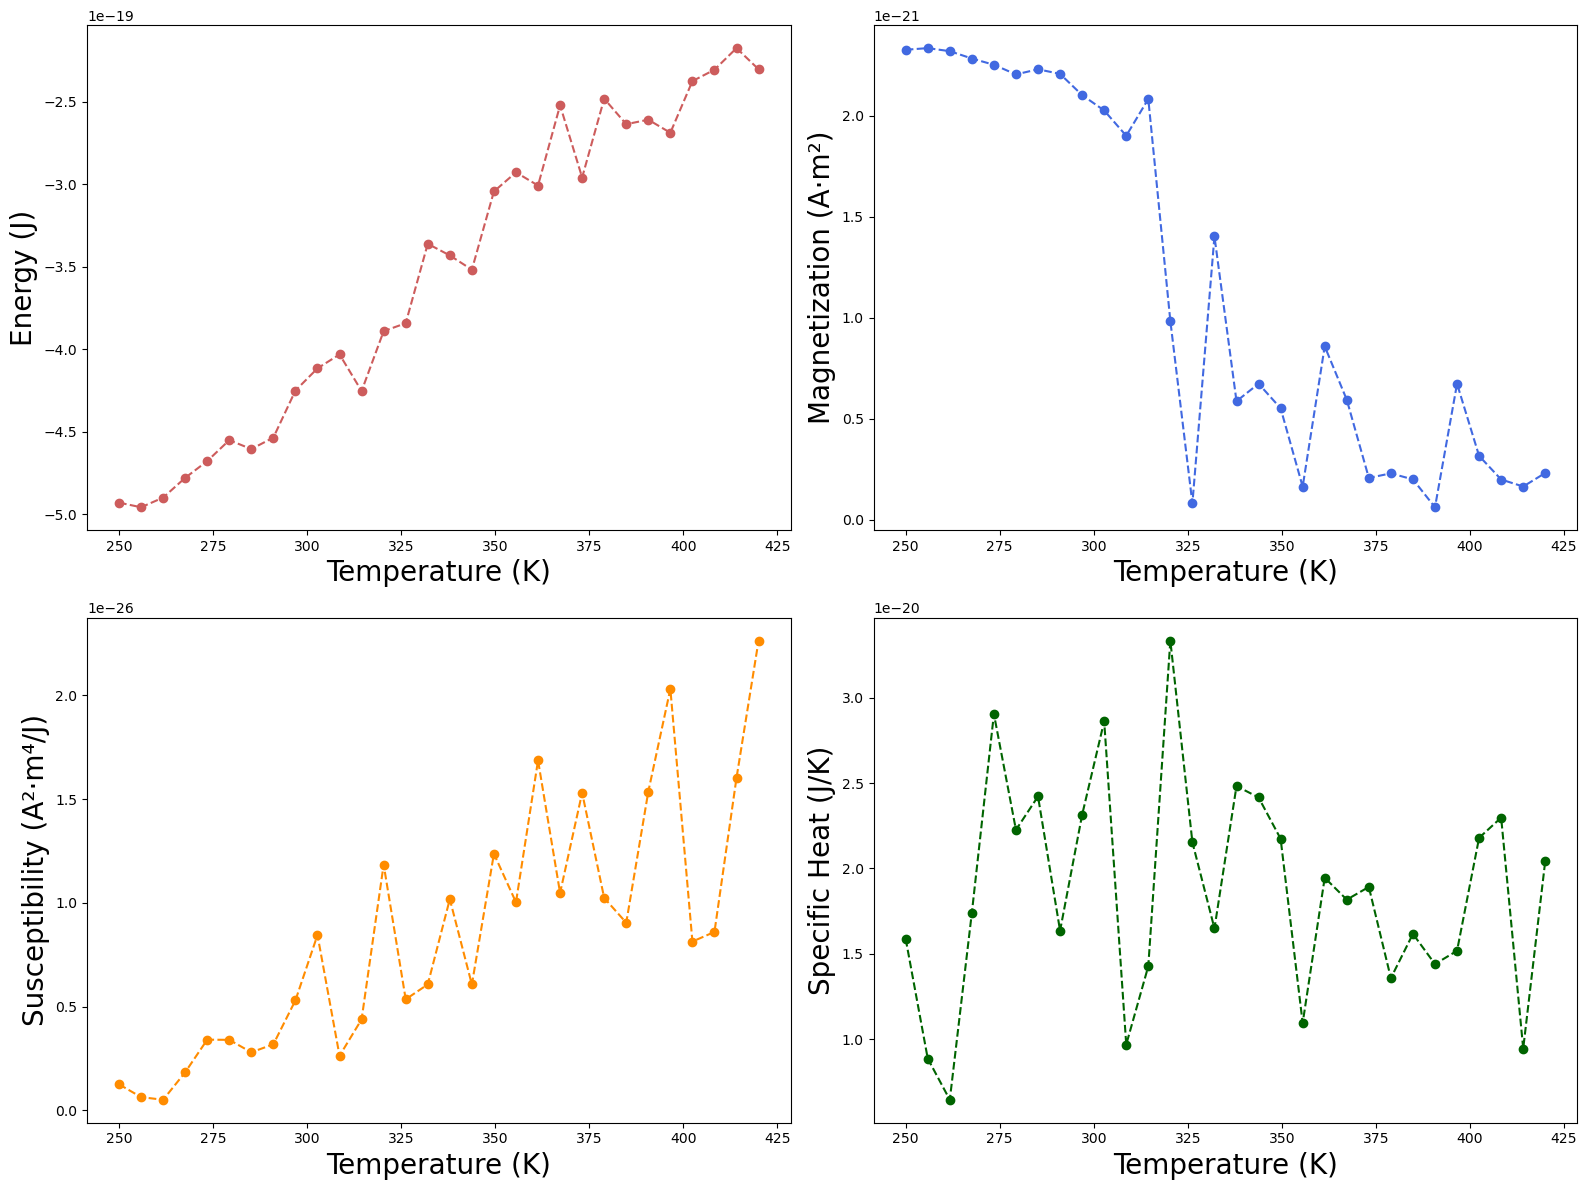

In [ ]:
k_B = 1.380649e-23       # J/K
J_phys = 2.0e-21         # J
mu_phys = 9.2740100783e-24      # J/T

nT = 30  # Number of temperature points
T_phys = np.linspace(250, 420, nT)  # K
h_phys = 0.0  # T


T_c = 2.269
T = T_phys * (k_B / J_phys)  # Dimensionless temperature
h = h_phys * (mu_phys / J_phys)  # Dimensionless field
J = 1.0
mu = mu_phys / J_phys  # Dimensionless magnetic moment

steps = 5000
eps = 1e-3
window = 400  # Number of steps to check for equilibrium
n_samples = 1500  # Number of steps to collect after equilibrium
N_runs = 80  # Number of simulations per temperature
grid_size = 16  # Size of the grid for the Ising model

energies = np.zeros(nT)
magnetization = np.zeros(nT)
susceptibility = np.zeros(nT)
specific_heat = np.zeros(nT)

for kT in range(nT):
    
    ising_model = IsingModel(grid_size=grid_size, temperature=T[kT], J=J, h=h, mu=mu)
    scalings = (J_phys, mu_phys)

    E1_phys = M1_phys = susceptibility1 = specific_heat1 = 0.0  


    for _ in range(N_runs):

        E_phys, M_phys, susceptibility_phys, specific_heat_phys, spin_grids, equilibrium_energies, equilibrium_magnetizations = Metropolis_hastings_for_equilibrium(
            ising_model, steps, scalings, eps=eps, window=window, n=n_samples, mu_phys=mu_phys, J_phys=J_phys)
        
        E1_phys += E_phys
        M1_phys += M_phys
        susceptibility1 += susceptibility_phys
        specific_heat1 += specific_heat_phys

    energies[kT] = E1_phys / N_runs
    magnetization[kT] = M1_phys / N_runs
    susceptibility[kT] = susceptibility1 / N_runs
    specific_heat[kT] = specific_heat1 / N_runs

    print(nT)


plot(T_phys, energies, magnetization, susceptibility, specific_heat)